# <span style="color:#F72585"><center>Tutorial de Stan</center></span>


## <span style="color:#4361EE">Introducción</span>


Se introducen los elementos esenciales del uso de Stan. En este cuaderno usamos el ejemplo de 8 escuelas (eight schools) {cite}`gelman2003bayesian` que utilizamos en el [primer ejemplo de este curso](1_Ocho_Escuelas)

## <span style="color:#4361EE">El modelo estadístico para este tutorial</span>


Supongamos que tenemos observaciones $[y_n |x_n], n=1,\ldots,N$, y asumamos el modelo Bayesiano. 

**Modelo con efectos aleatorios**

- Estima los hiperparámetros $\mu$ and $\tau$
- Predice los efectos aleatorios $\eta_i$


$$
\begin{align}
y_i &\sim \mathcal{N}(\theta_i,\sigma_i^2), \text{ known } \sigma_i^2\\
\theta_i & = \mu + \tau \times \eta_i \\
\eta_i &\sim \mathcal{N}(0, 1)\\
\mu &\propto 1\\
\tau &\propto 1
\end{align}
$$


### <span style="color:#4CC9F0">Los datos</span>

Los datos corresponden a la estimación (estandarizada) de un puntaje realizada en las ocho escuelas observadas.


```{table}
|School |Estim. Treatment Effect | Estim. Stand. Error |
|---|---|---|
|A |28| 15|
|B |8 |10|
|C| -3| 16|
|D| 7| 11|
|E| -1 |9|
|F| 1| 11|
|G |18| 10|
|H| 12| 18|
```

In [1]:
# importamos las librerías requieridas
import pystan
import numpy as np
# Se requiren instaladas las libreria matplotlib and scipy pra los gráficos 


ModuleNotFoundError: No module named 'pystan'

In [29]:
# los datos
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])

schools_dat = {'J': J,
               'y': y,
               'sigma': sigma}
schools_dat 

{'J': 8,
 'y': array([28.,  8., -3.,  7., -1.,  1., 18., 12.]),
 'sigma': array([15., 10., 16., 11.,  9., 11., 10., 18.])}

In [4]:
print(type(schools_dat))
print(schools_dat['y'])

<class 'dict'>
[28, 8, -3, 7, -1, 1, 18, 12]


## <span style="color:#4361EE">Implementación del modelo estadístico en Stan</span>


In [5]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""


In [7]:
print(schools_code)


data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}



En este código los parámetros que serán muestreados son $\mu$ (*mu*), $\tau$ (*tau*), que es una desviación estándar y los $\eta_i$ (*eta*) que son los efectos aleatorios en el modelo. Las medias $\theta_i$ de las escuelas son calculados. Es decir, son funcionales de los parámetros.

## <span style="color:#4361EE">Compilación del modelo</span>


In [34]:
# compile the  model
sm = pystan.StanModel(model_code=schools_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19a09b474d1901f191444eaf8a6b8ce2 NOW.


In [35]:
# extract the samples
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

In [36]:
fit

Inference for Stan model: anon_model_19a09b474d1901f191444eaf8a6b8ce2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          8.0    0.14    5.0  -2.49   4.82   8.02  11.26  17.82   1302    1.0
tau        6.63    0.21   5.72    0.2   2.38   5.31   9.25  20.34    774    1.0
eta[1]      0.4    0.02   0.91  -1.39   -0.2   0.42   0.99   2.21   1518    1.0
eta[2]   5.1e-3    0.02   0.87  -1.68  -0.56  -0.01   0.58   1.76   2146    1.0
eta[3]     -0.2    0.02   0.91   -2.0  -0.81  -0.21    0.4   1.58   2062    1.0
eta[4]  -2.2e-4    0.02   0.89  -1.78  -0.57 9.9e-3   0.56   1.82   1909    1.0
eta[5]    -0.35    0.02   0.86   -2.0  -0.94  -0.36   0.23   1.39   1941    1.0
eta[6]    -0.22    0.02   0.89  -1.98  -0.82  -0.26   0.36   1.64   1878    1.0
eta[7]     0.35    0.02   0.87  -1.42  -0.23   0.37   0.95    2.0   1945    1.0
eta[8]     0.

Una vez el modelo es compilado, se pueden generar muestras cuando se desee. Por ejemplo:

In [ ]:
fit2 = sm.sampling(data=schools_dat, iter=1000, chains=4)

## <span style="color:#4361EE">Optimización en Stan. Moda Posterior</span>


El modelos compilado puede usarse para optimizar la posterior, lo que lleva a la moda posterior (MAP)

In [37]:
op = sm.optimizing(data=schools_dat)
op

OrderedDict([('mu', array(1.89701311)),
             ('tau', array(31209.61403927)),
             ('eta',
              array([ 8.36360579e-04,  1.95546395e-04, -1.56904161e-04,  1.63501462e-04,
                     -9.28237803e-05, -2.87409680e-05,  5.15953816e-04,  3.23703712e-04])),
             ('theta',
              array([27.99950399,  7.99994062, -2.99990519,  6.99983062, -0.99998125,
                      1.00001859, 17.99973258, 11.99968101]))])

## <span style="color:#4361EE">Métodos del objeto sm.sampling</span>


El objeto fit retornado por sm.sampling almacena muestras de la distribución posterior, junto con las estadísticas del tamaño efectivo de muestra $n_eff$,  la estadística $\hat{R}$ y el logaritmo de la posterior *lp__*.

Hay varios métodos disponibles con el objeto fit. Revisamos aquí, *extract* y *plot*.


In [15]:
la = fit.extract(permuted=True)  # return a dictionary of arrays
mu = la['mu']
print("muestra de mu=\n", mu)
print("Tamaño de la muestra=", mu.shape)

muestra de mu=
 [ 9.82721174  5.09147837  7.60869614 ... -3.38947094  4.75115144
  6.51837058]
Tamaño de la muestra= (2000,)


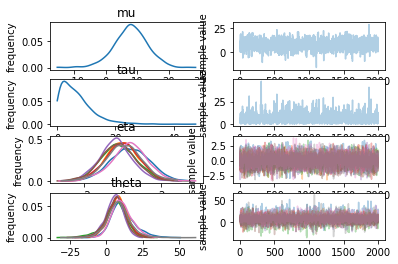

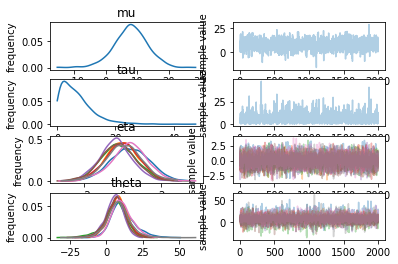

In [26]:
fit.plot()

## <span style="color:#4361EE">Guardar y reusar el modelo</span>


In [39]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(sm, f, protocol=pickle.HIGHEST_PROTOCOL)

# load it at some future point
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# run with different data
fit2 = model.sampling(data=schools_dat)

In [40]:
fit2

Inference for Stan model: anon_model_19a09b474d1901f191444eaf8a6b8ce2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         8.03     0.1   5.06  -2.01   4.82   8.03  11.15  18.54   2390    1.0
tau        6.48    0.13   5.45    0.2   2.37   5.24   9.07  21.34   1731    1.0
eta[1]     0.39    0.01   0.95  -1.55  -0.22   0.41   1.02   2.17   4370    1.0
eta[2]    -0.01    0.01   0.89  -1.79  -0.59  -0.01   0.57   1.75   3799    1.0
eta[3]    -0.18    0.01   0.95  -2.01  -0.82  -0.21   0.43   1.78   4166    1.0
eta[4]    -0.05    0.01   0.89  -1.83  -0.62  -0.06   0.52   1.75   3883    1.0
eta[5]    -0.35    0.02   0.88  -2.05  -0.92  -0.36    0.2   1.46   2857    1.0
eta[6]    -0.22    0.01    0.9  -1.98  -0.81  -0.23   0.35   1.58   3805    1.0
eta[7]     0.32    0.01   0.88  -1.44  -0.25   0.33    0.9   2.03   3649    1.0
eta[8]     

## <span style="color:#4361EE">Referencias</span>


https://statmodeling.stat.columbia.edu/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/


[PyStan: Getting Started](https://pystan.readthedocs.io/en/latest/getting_started.html)


[Manual de usuario de Stan, versión 2.22](https://mc-stan.org/docs/2_22/stan-users-guide/index.html)


[ArviZ: Exploratory analysis of Bayesian models](https://arviz-devs.github.io/arviz/)

```{bibliography}
:filter: docname in docnames
```